In [16]:
# adds scripts/ and src/ folder: so you can import scripts/functions across project steps
import sys 
sys.path.append("../../src")
sys.path.append("../../scripts")

from os import listdir
from os import path

import pandas as pd
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from data_filepaths import image_folders, portraits_csv, images_with_boxes_folder, object_detection_results_csv_folder

### choose model setup to investigate 

In [17]:
MODEL = "resnet"# model FasterRCNN+InceptionResNet V2: higher accuracy,
#MODEL = "mobilenet" # model ssd+mobilenet V2: small and fast.

CASE_STUDY_TITLE = "all_before1800_maxpixels1024x1024"

DETECTION_SCORE_THRESHOLD = 0.3

object_detection_results_csv_folder = object_detection_results_csv_folder.replace("<CASESTUDY>", CASE_STUDY_TITLE).replace("<MODEL>", MODEL)
images_with_boxes_folder = images_with_boxes_folder.replace("<CASESTUDY>", CASE_STUDY_TITLE).replace("<MODEL>", MODEL)


### load detected objects list

In [18]:
results_per_image = [
    pd.read_csv(path.join(object_detection_results_csv_folder, csv_path))
    for csv_path in listdir(object_detection_results_csv_folder)
]

def fix_byte_dirt(str):
    if len(str)<4:
        return str
    if str[0:2]=="b'":
        str = str[2:len(str)]
    if str[-1]=="'":
        str = str[0:-1]
    return str

for dtf in results_per_image:
    dtf.detection_class_entities = dtf.detection_class_entities.apply(fix_byte_dirt)

In [19]:
results_per_image[0]

Unnamed: 0  detection_scores detection_class_entities  \
0            0          0.702768                 Clothing   
1            1          0.665464                    Wheel   
2            2          0.584777               Human face   
3            3          0.570420                 Clothing   
4            4          0.536642                      Man   
..         ...               ...                      ...   
95          95          0.005703                  Bicycle   
96          96          0.005671                  Vehicle   
97          97          0.005408                Human arm   
98          98          0.005384                   Mammal   
99          99          0.005344                   Mirror   

    detection_class_labels        x0        y0        x1        y1  \
0                      433  0.321609  0.671318  0.879619  0.971259   
1                      409  0.770530  0.362391  0.994128  0.642139   
2                      502  0.245406  0.750022  0.359969  0.801035   
3                      433  0.352208  0.087993  0.823569  0.382483   
4                      308  0.205849  0.653073  0.928413  0.977721   
..                     ...       ...       ...       ...       ...   
95                      40  0.755285  0.293367  0.994306  0.677054   
96                     404  0.088383  0.058601  0.992078  0.974672   
97                     503  0.471705  0.098005  0.563441  0.165668   
98                     298  0.388600  0.058572  0.694624  0.148686   
99                     318  0.040427  0.061746  0.953222  0.862764   

   new_filename  
0     21493.jpg  
1     21493.jpg  
2     21493.jpg  
3     21493.jpg  
4     21493.jpg  
..          ...  
95    21493.jpg  
96    21493.jpg  
97    21493.jpg  
98    21493.jpg  
99    21493.jpg  

[100 rows x 9 columns]

In [20]:
# ,detection_class_labels,detection_class_entities,detection_scores,x0,y0,x1,y1,new_filename
relevant_columns = ["detection_class_labels", "detection_class_entities", "detection_scores", "new_filename"]

def unique_detection_classes(result_dtf):
    return result_dtf[relevant_columns].groupby(
        ['detection_class_labels', "detection_class_entities", "new_filename"], as_index=False).agg(
        {'detection_scores':max}
    )

In [21]:
global_uresults = pd.concat([unique_detection_classes(res) for res in results_per_image])
global_uresults = global_uresults[global_uresults.detection_scores>DETECTION_SCORE_THRESHOLD]

In [22]:
global_uresults

detection_class_labels detection_class_entities new_filename  \
3                       69                   Person    21493.jpg   
8                      228                    Woman    21493.jpg   
13                     308                      Man    21493.jpg   
19                     409                    Wheel    21493.jpg   
21                     433                 Clothing    21493.jpg   
..                     ...                      ...          ...   
30                     561                   Animal    89729.jpg   
0                       69                   Person    32042.jpg   
4                      308                      Man    32042.jpg   
6                      391                     Tree    32042.jpg   
7                      433                 Clothing    32042.jpg   

    detection_scores  
3           0.438744  
8           0.426963  
13          0.536642  
19          0.665464  
21          0.702768  
..               ...  
30          0.471954  
0           0.356143  
4           0.325303  
6           0.551430  
7           0.480922  

[6986 rows x 4 columns]

### Global statistics

In [23]:
nb_portraits_per_object_class = global_uresults.groupby(
        ['detection_class_labels', "detection_class_entities"], as_index=False).agg(
        {'detection_scores':max, "new_filename": "nunique"}
    )
nb_portraits_per_object_class["nb_portraits"] = nb_portraits_per_object_class["new_filename"]
del nb_portraits_per_object_class["new_filename"]
nb_portraits_per_object_class.sort_values(by="nb_portraits", ascending=False, inplace=True)
nb_portraits_per_object_class[0:40]

detection_class_labels detection_class_entities  detection_scores  \
106                     433                 Clothing          0.952994   
131                     502               Human face          0.992410   
16                       69                   Person          0.939582   
55                      228                    Woman          0.946834   
73                      308                      Man          0.976793   
90                      391                     Tree          0.987420   
107                     434                 Footwear          0.872777   
142                     561                   Animal          0.987029   
118                     462                 Building          0.968263   
13                       58                    Dress          0.937307   
85                      359                Sculpture          0.882505   
65                      277        Fashion accessory          0.883007   
86                      366            Picture frame          0.996424   
24                       99                   Poster          0.868176   
12                       51                      Boy          0.936126   
59                      242                    Horse          0.996403   
112                     446                      Dog          0.989844   
40                      161                      Hat          0.889156   
76                      333                     Girl          0.815258   
10                       43                     Boat          0.987923   
115                     456                   Flower          0.895460   
69                      292               Human head          0.645757   
58                      241                    House          0.880315   
71                      298                   Mammal          0.808305   
121                     466                Furniture          0.799989   
77                      334                    Plant          0.657671   
14                       67                    Tower          0.868808   
5                        22                     Bird          0.995593   
45                      193                     Food          0.769497   
52                      221                Human leg          0.643894   
26                      115                   Cattle          0.877498   
23                       97                    Chair          0.931571   
66                      281                    Table          0.776996   
128                     487                   Castle          0.957647   
97                      409                    Wheel          0.885654   
4                        21              Human beard          0.744548   
100                     419                     Lion          0.972471   
146                     573               Human hand          0.736671   
44                      186                     Vase          0.974442   
31                      125                  Gondola          0.961399   

     nb_portraits  
106          1275  
131          1205  
16            964  
55            858  
73            781  
90            271  
107           132  
142           111  
118           107  
13             99  
85             80  
65             74  
86             73  
24             71  
12             58  
59             51  
112            50  
40             49  
76             42  
10             29  
115            25  
69             24  
58             23  
71             21  
121            18  
77             18  
14             17  
5              16  
45             16  
52             15  
26             15  
23             14  
66             14  
128            13  
97             12  
4              12  
100            12  
146            11  
44             11  
31              9

In [24]:
nb_portraits_per_object_class[40:80]

detection_class_labels detection_class_entities  detection_scores  \
114                     448                 Elephant          0.811415   
22                       91                Carnivore          0.866107   
48                      203                    Fruit          0.473327   
127                     485                   Window          0.689362   
50                      216                   Jacket          0.606768   
119                     463                     Fish          0.892262   
132                     503                Human arm          0.485296   
29                      120                     Suit          0.459602   
41                      164                   Fedora          0.801505   
137                     515                Flowerpot          0.629349   
94                      404                  Vehicle          0.864031   
51                      219                   Guitar          0.962095   
61                      253               Human hair          0.407956   
30                      122                      Cat          0.993944   
21                       90                 Necklace          0.854615   
110                     441               Wine glass          0.814269   
7                        30                    Skull          0.982427   
109                     437                     Deer          0.964652   
63                      263                   Insect          0.692993   
117                     459                Palm tree          0.664509   
125                     479                Butterfly          0.982563   
98                      415                      Jug          0.744008   
88                      380                    Sheep          0.736295   
151                     601                   Helmet          0.727288   
39                      160                     Door          0.761596   
62                      257                  Curtain          0.790938   
28                      119                     Coat          0.725451   
27                      118                    Camel          0.684974   
56                      233               Houseplant          0.788079   
18                       71                 Swimwear          0.500395   
133                     504                Vegetable          0.702447   
38                      152                 Dinosaur          0.418508   
99                      418                   Monkey          0.982092   
81                      349                      Pig          0.833920   
78                      340                  Pumpkin          0.656648   
64                      267             Invertebrate          0.470121   
70                      293                     Bowl          0.725426   
68                      286                   Bottle          0.902033   
75                      318                   Mirror          0.715172   
134                     507                   Falcon          0.463838   

     nb_portraits  
114             9  
22              9  
48              8  
127             8  
50              7  
119             7  
132             7  
29              7  
41              6  
137             6  
94              6  
51              6  
61              6  
30              5  
21              5  
110             5  
7               5  
109             5  
63              4  
117             4  
125             4  
98              4  
88              4  
151             4  
39              4  
62              4  
28              4  
27              4  
56              4  
18              4  
133             3  
38              3  
99              3  
81              3  
78              3  
64              3  
70              3  
68              3  
75              3  
134             2

### Getting images with given objects combinations

In [25]:
results_per_image[0]

Unnamed: 0  detection_scores detection_class_entities  \
0            0          0.702768                 Clothing   
1            1          0.665464                    Wheel   
2            2          0.584777               Human face   
3            3          0.570420                 Clothing   
4            4          0.536642                      Man   
..         ...               ...                      ...   
95          95          0.005703                  Bicycle   
96          96          0.005671                  Vehicle   
97          97          0.005408                Human arm   
98          98          0.005384                   Mammal   
99          99          0.005344                   Mirror   

    detection_class_labels        x0        y0        x1        y1  \
0                      433  0.321609  0.671318  0.879619  0.971259   
1                      409  0.770530  0.362391  0.994128  0.642139   
2                      502  0.245406  0.750022  0.359969  0.801035   
3                      433  0.352208  0.087993  0.823569  0.382483   
4                      308  0.205849  0.653073  0.928413  0.977721   
..                     ...       ...       ...       ...       ...   
95                      40  0.755285  0.293367  0.994306  0.677054   
96                     404  0.088383  0.058601  0.992078  0.974672   
97                     503  0.471705  0.098005  0.563441  0.165668   
98                     298  0.388600  0.058572  0.694624  0.148686   
99                     318  0.040427  0.061746  0.953222  0.862764   

   new_filename  
0     21493.jpg  
1     21493.jpg  
2     21493.jpg  
3     21493.jpg  
4     21493.jpg  
..          ...  
95    21493.jpg  
96    21493.jpg  
97    21493.jpg  
98    21493.jpg  
99    21493.jpg  

[100 rows x 9 columns]

In [26]:
def get_images_with_objects_combination(results_per_image,
                                        detection_class_entities_list,
                                        detection_scores_threshold=DETECTION_SCORE_THRESHOLD):
        """Returns the 'new_filename' of the images containing all the specified given detection_class_entities
                
        Only consider entities with detection score above given threshold
        """
        img_objects = [
            (dtf.new_filename[0], set(dtf.detection_class_entities[dtf.detection_scores>detection_scores_threshold]))
            for dtf in results_per_image if dtf.shape[0]>0
        ]
        
        return [image_name for image_name, detected_objects in img_objects if all(c in detected_objects for c in detection_class_entities_list)]
        
        

In [27]:
results_per_image[0].new_filename[0]

'21493.jpg'

In [28]:
def show_images(images_paths, path_prefix=None, columns=3):
    

    # setting values to rows and column variables
    rows = int(np.ceil(len(images_paths)/float(columns)))
    columns = int(columns)
    
    # create figure
    fig = plt.figure(figsize=(15,5*rows))
    
    for i, img_path in enumerate(images_paths):
        if path_prefix is not None:
            img_path = path.join(path_prefix, img_path)
        img = Image.open(img_path)
        
        fig.add_subplot(rows, columns, i+1)

        # showing image
        plt.imshow(img)
        plt.axis('off')
        plt.title(path.basename(img_path))

In [14]:
selected_images = get_images_with_objects_combination(results_per_image, ["Dog"])
#images_with_animals
len(selected_images)

50

In [29]:
get_images_with_objects_combination(results_per_image, ["Dog"])


['102832.jpg',
 '49474.jpg',
 '8750.jpg',
 '32724.jpg',
 '64605.jpg',
 '91724.jpg',
 '12360.jpg',
 '100999.jpg',
 '94505.jpg',
 '15179.jpg',
 '28612.jpg',
 '100219.jpg',
 '17443.jpg',
 '79069.jpg',
 '20447.jpg',
 '6140.jpg',
 '40060.jpg',
 '70307.jpg',
 '20948.jpg',
 '54689.jpg',
 '69737.jpg',
 '81698.jpg',
 '37898.jpg',
 '27380.jpg',
 '1068.jpg',
 '14942.jpg',
 '75100.jpg',
 '28046.jpg',
 '69455.jpg',
 '6809.jpg',
 '26346.jpg',
 '67854.jpg',
 '50890.jpg',
 '102511.jpg',
 '62272.jpg',
 '39739.jpg',
 '83133.jpg',
 '68546.jpg',
 '54327.jpg',
 '91576.jpg',
 '40537.jpg',
 '50996.jpg',
 '51531.jpg',
 '1446.jpg',
 '36988.jpg',
 '2321.jpg',
 '78741.jpg',
 '60830.jpg',
 '1772.jpg',
 '89729.jpg']

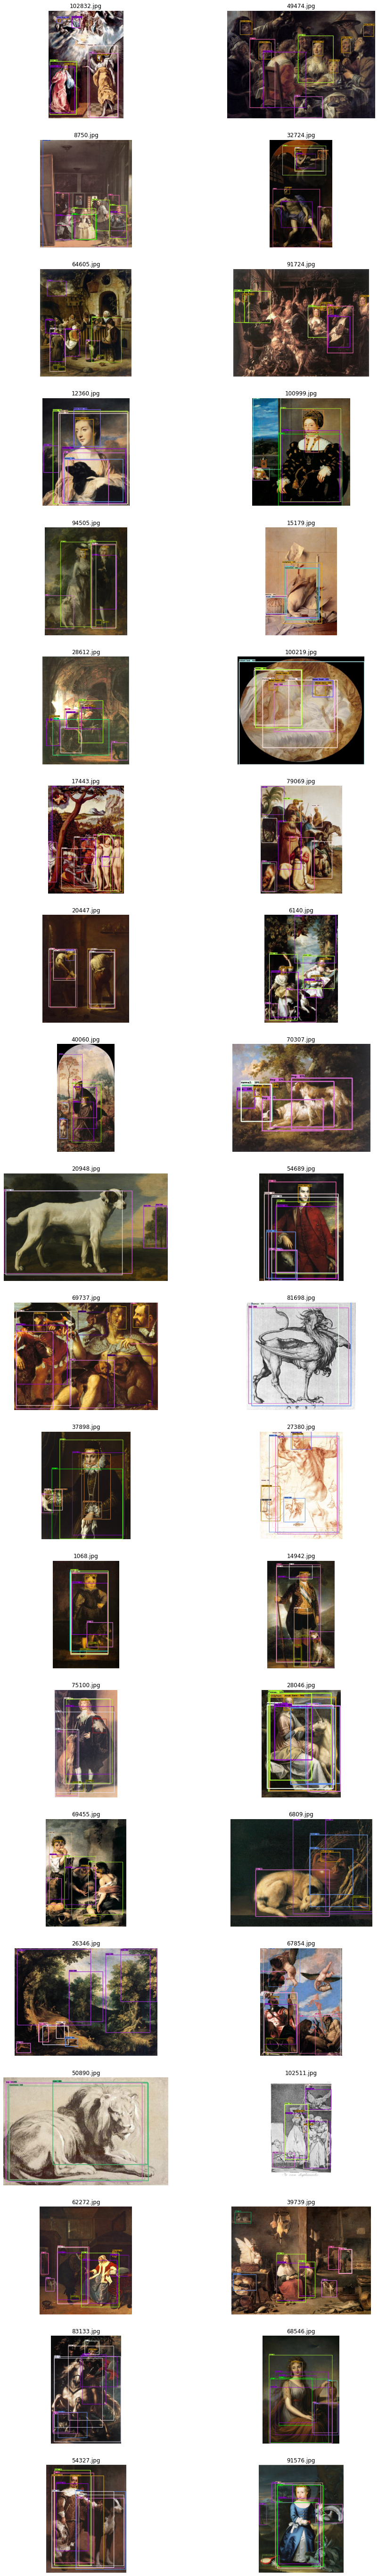

In [15]:

show_images(selected_images[0:40], images_with_boxes_folder,2)